In [1]:
%matplotlib inline

In [16]:
import pandas as pd
import sklearn.preprocessing as sk
from scipy.sparse import csc_matrix


In [3]:
df = (pd.read_csv("../input/h_2_courses.csv")
        .rename(columns={"наименование": "course_name", "max-score, максим который набрать": "max_possible_score", 
                         "проходной ли балл?": "is_passed", "сам ли назначил?": "does_he_appointed",
                         "когда активирован курс": "course_activated_at", "когда завершен": "course_finished_at",
                         "в срок ли завершен": "completed_in_period"
                        })
        .drop(['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 
               'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'], 1)
        .assign(course_activated_at = lambda x: pd.to_datetime(x["course_activated_at"], dayfirst=True))
        .assign(course_finished_at = lambda x: pd.to_datetime(x["course_finished_at"], dayfirst=True))
     )

In [4]:
df

,uid,course_name,max_possible_score,score,%,is_passed,does_he_appointed,course_activated_at,course_finished_at,completed_in_period
0,u995,Служба обслуживания сотрудников,100,100.00,100.000000,1,0,2014-10-21,2014-10-24,1.0
1,u995,"Обучающий курс: ""Эффективная работа с кросс-ма...",100,100.00,100.000000,1,0,2014-10-08,2014-10-13,1.0
2,u995,Технология продаж кухонной техники,100,100.00,100.000000,1,1,2014-10-01,2014-10-01,NaN
3,u995,Технология продаж кухонной техники,100,98.75,98.750000,1,1,2014-09-27,2014-09-27,NaN
4,u995,Маркетинговая акция осени,100,100.00,100.000000,1,0,2014-09-22,2014-09-26,1.0
5,u995,Создание красивых презентаций.,0,0.00,NaN,0,1,2014-09-12,2014-09-12,NaN
6,u995,Оборудование Apple,100,100.00,100.000000,1,1,2014-09-10,2014-09-27,NaN
7,u995,Спасибо от Сбербанка_часть 3,100,90.00,90.000000,1,0,2014-09-01,2014-09-10,1.0
8,u995,Программа СПАСИБО от Сбербанка,100,93.30,93.300000,1,0,2014-08-16,2014-08-20,1.0
9,u995,CRM - Управление взаимоотношениями с клиентами,0,217.00,NaN,0,1,2014-07-22,2014-09-26,0.0


In [101]:
course_encoder = sk.LabelEncoder()
user_encoder = sk.LabelEncoder()

prepeared = (df.drop(["max_possible_score", "score", "%", "completed_in_period"], 1)
           .assign(duration = lambda x: x["course_finished_at"] - x["course_activated_at"])
           .drop(["course_finished_at", "course_activated_at"], 1)
           .assign(is_passed = lambda x: x.is_passed.apply(lambda el: 2 * el - 1))
           .assign(cid = lambda x: course_encoder.fit_transform(x.course_name))
           .assign(uid = lambda x: user_encoder.fit_transform(x.uid))
           .drop(["course_name"], 1)
        )

train = prepeared.groupby(["uid", "cid"])["is_passed"].max().reset_index()

In [76]:
from scipy.sparse import coo_matrix, csr_matrix

def convert_to_sparse(src):
    data = []
    row = []
    col = []
    
    for k in src:
        data.append(k[2])
        row.append(k[0])
        col.append(k[1])
    return coo_matrix((data, (row, col)))

In [57]:
from lightfm import LightFM

In [77]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def training(X):
    _cf_model = LightFM()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    res = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        _cf_model.fit(convert_to_sparse(X_train))
        
        res.append(mean_squared_error(_cf_model.predict(X_test[:,0], X_test[:,1]), X_test[:,2]))
    return np.array(res).mean()

training(train.as_matrix())

0.64676186355036291

In [98]:
cf_model = LightFM(no_components=30)
cf_model.fit(convert_to_sparse(train.as_matrix()))

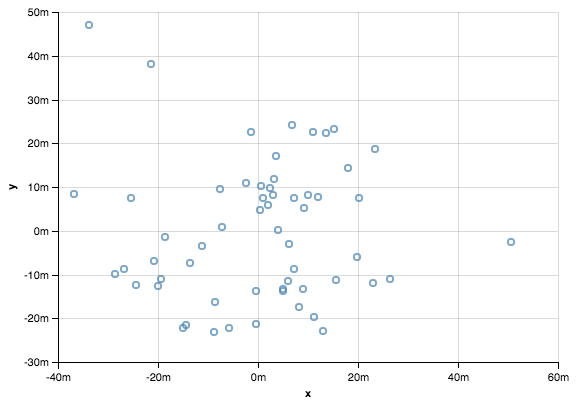

In [99]:
from altair import Chart
from sklearn.decomposition import PCA

courses_2d_presentation = PCA(n_components=2).fit_transform(cf_model.item_embeddings)
courses_2d_presentation_df = pd.DataFrame({'x': courses_2d_presentation[:,0], 'y': courses_2d_presentation[:,1]})

Chart(courses_2d_presentation_df).mark_point().encode(x = 'x', y = 'y')

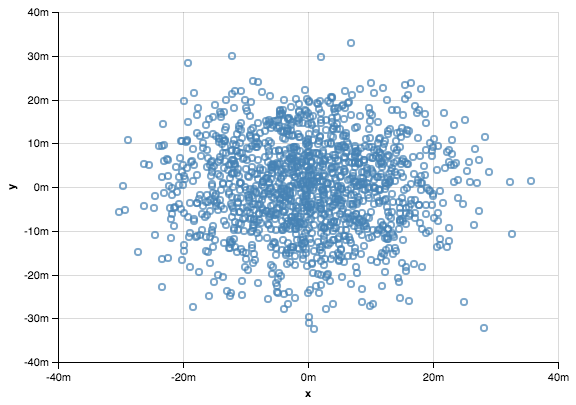

In [100]:

users_2d_presentation = PCA(n_components=2).fit_transform(cf_model.user_embeddings)
users_2d_presentation_df = pd.DataFrame({'x': users_2d_presentation[:,0], 'y': users_2d_presentation[:,1]})

Chart(users_2d_presentation_df).mark_point().encode(x = 'x', y = 'y')

In [111]:
def uid_feature_matrix():
    res = []
    for uid in prepeared.uid.as_matrix():
        res.append(cf_model.user_embeddings[uid])
    return np.array(res)

uid_feature_matrix().shape

(16229, 30)

In [112]:
def cid_feature_matrix():
    res = []
    for cid in prepeared.cid.as_matrix():
        res.append(cf_model.item_embeddings[cid])
    return np.array(res)

cid_feature_matrix().shape

(16229, 30)

In [116]:
def does_he_appointed_feature_matrix():
    return pd.get_dummies(prepeared.does_he_appointed).as_matrix()

In [118]:
def duration_feature_matrix():
    return pd.get_dummies(prepeared.duration).as_matrix()

In [138]:
X = np.hstack((cid_feature_matrix(), does_he_appointed_feature_matrix(), 
               duration_feature_matrix()))
y = prepeared.is_passed.apply(lambda x: (x + 1) / 2).as_matrix()

In [137]:
X.shape

(16229, 256)

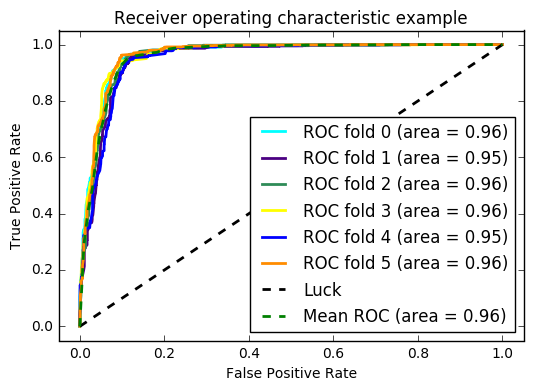

In [139]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegressionCV()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [134]:
classifier.coef_

array([[  -1.45437285,   -0.35298195,   -2.19408151,   -1.69355995,
           3.83893058,   -5.12785741,    1.16632687,   -0.1741085 ,
          -7.49273287,    0.52807763,   13.37770934,    4.91856286,
          -9.99975097,   -8.10425029,    7.74602476,   11.51112123,
          10.63274256,   10.07577409,   -0.50946524,   -0.43986908,
          -0.39493852,   -3.76051733,   -6.30812022,    0.64749712,
           4.11525752,    7.71356241,    2.60357256,    2.22728274,
          -6.03813218,   -7.99288789,   89.65534298,  -52.00253114,
          64.58355911,   54.7081085 ,  -15.16510667,   12.10644328,
         -29.226056  ,   85.61201552,   -3.94664787,   62.58070964,
          83.02886161,   19.90730148,  -21.65536486,  -32.45727177,
         -51.87142979,   90.59776261,  -31.86390321,   36.38367961,
          68.34315547,  144.20941322,  -50.55950327,   30.29214362,
        -116.2445324 ,   -6.78438163,   64.51128832,  -51.8956749 ,
         122.84040916,   12.0342417 ,   63.13782